In [1]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import sys
# !{sys.executable} -m pip install seaborn

In [3]:
dirname = os.getcwd()
ROOT = os.path.join(dirname, "105_classes_pins_dataset")
dims = (192,192)

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.resize(image, dims)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [4]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        if not folder.startswith("pins"):
            continue
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        if not folder.startswith("pins"):
            continue
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

Length of training list: 94
Length of testing list : 11


In [5]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
                
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, files[i])
                positive = (folder, files[j])

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_path = os.path.join(directory, neg_folder)
                neg_files = list(os.listdir(neg_path))[:max_files]
                neg_file = random.randint(0, len(neg_files)-1)
                negative = (neg_folder, neg_files[neg_file])

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [6]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 4230
Number of testing triplets : 495

Examples of triplets:
(('pins_Tom Hiddleston', 'Tom Hiddleston185_1490.jpg'), ('pins_Tom Hiddleston', 'Tom Hiddleston228_1517.jpg'), ('pins_Johnny Depp', 'Johnny Depp73_1928.jpg'))
(('pins_Amanda Crew', 'Amanda Crew5_84.jpg'), ('pins_Amanda Crew', 'Amanda Crew15_32.jpg'), ('pins_Krysten Ritter', 'Krysten Ritter25_1809.jpg'))
(('pins_Mark Ruffalo', 'Mark Ruffalo131_3202.jpg'), ('pins_Mark Ruffalo', 'Mark Ruffalo104_3189.jpg'), ('pins_camila mendes', 'camila mendes97_1110.jpg'))
(('pins_Robert Downey Jr', 'Robert Downey Jr51_4282.jpg'), ('pins_Robert Downey Jr', 'Robert Downey Jr119_4097.jpg'), ('pins_Stephen Amell', 'Stephen Amell27_4192.jpg'))
(('pins_Lindsey Morgan', 'Lindsey Morgan6_2251.jpg'), ('pins_Lindsey Morgan', 'Lindsey Morgan188_2190.jpg'), ('pins_Jennifer Lawrence', 'Jennifer Lawrence168_1642.jpg'))


In [7]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

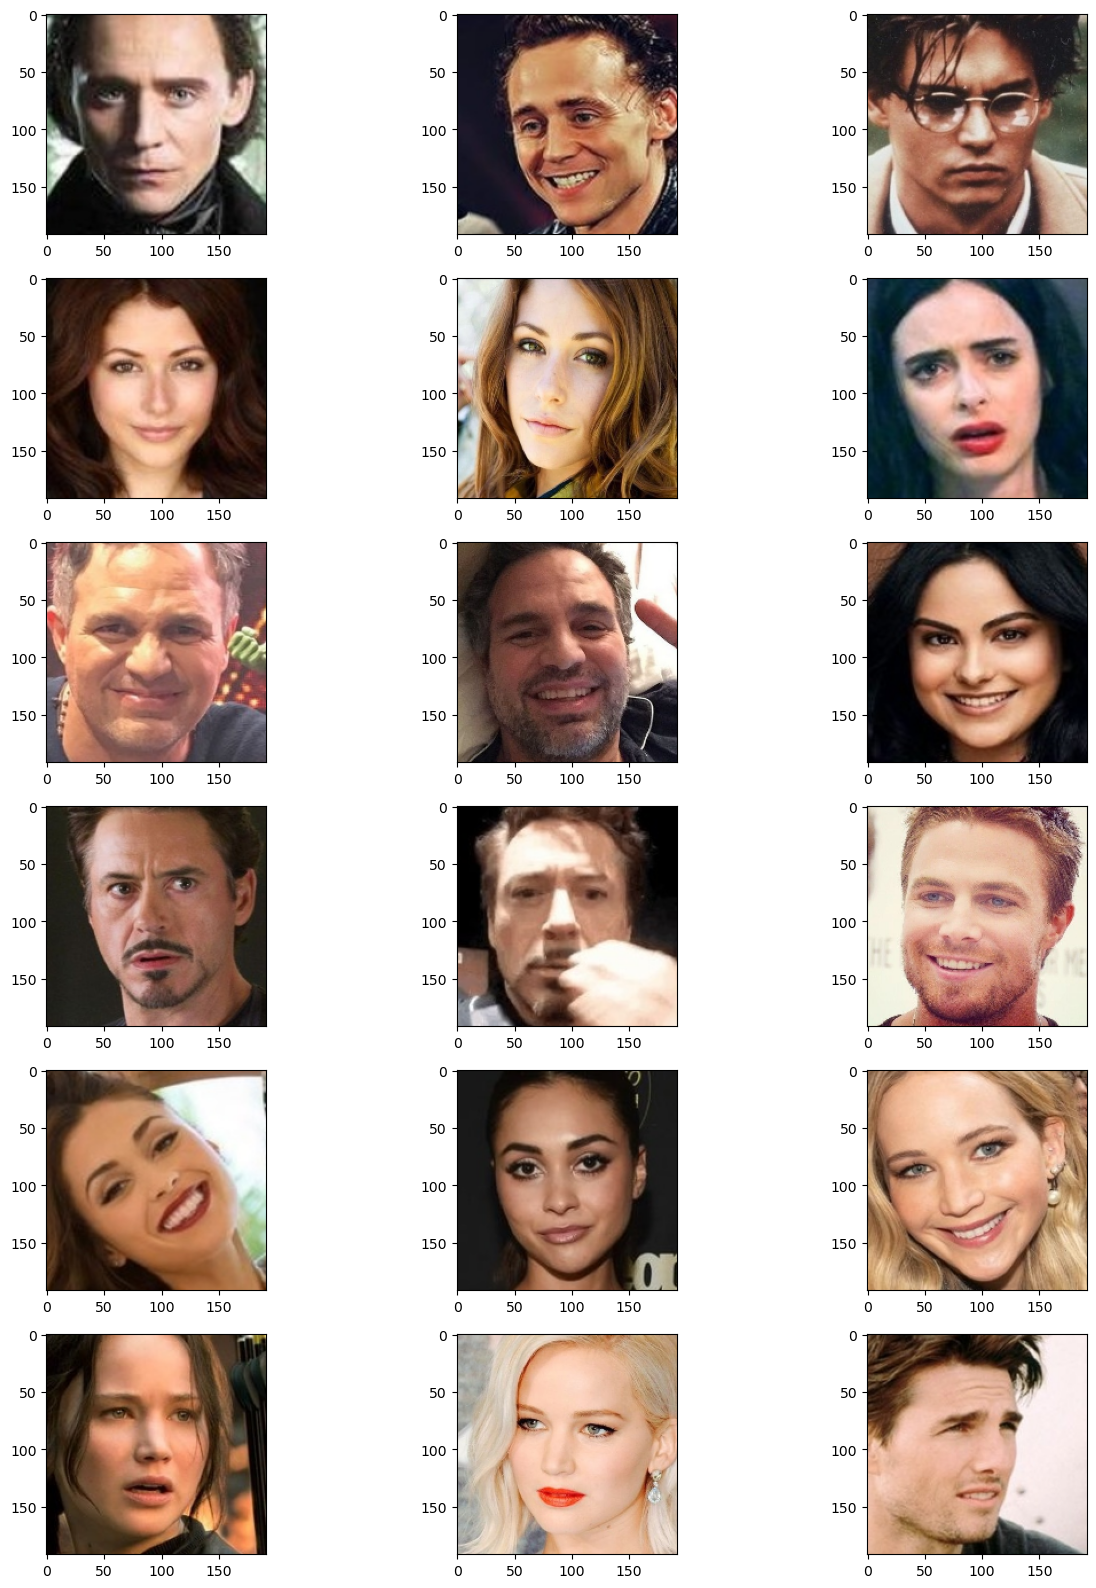

In [8]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [9]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [10]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [11]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (dims[0], dims[1], 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

2023-05-01 14:23:58.938545: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-01 14:23:58.938915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 192, 192, 3  0           []                               
                                )]                

In [12]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [13]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [14]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [15]:
save_all = False
epochs = 10
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model-192-mid")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-192")

2023-05-01 14:24:04.666475: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-01 14:24:04.670995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-05-01 14:25:54.222005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



EPOCH: 1 	 (Epoch done in 114 sec)
Loss on train    = 0.58627


2023-05-01 14:25:56.689721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 540ms/step


2023-05-01 14:26:05.093489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 4s 650ms/step
Accuracy on test = 0.75758

EPOCH: 2 	 (Epoch done in 108 sec)
Loss on train    = 0.46088
4/4 [==============================] - 2s 491ms/step
Accuracy on test = 0.79394

EPOCH: 3 	 (Epoch done in 106 sec)
Loss on train    = 0.35957
4/4 [==============================] - 2s 649ms/step
Accuracy on test = 0.80202

EPOCH: 4 	 (Epoch done in 107 sec)
Loss on train    = 0.28806
4/4 [==============================] - 2s 491ms/step
Accuracy on test = 0.77172

EPOCH: 5 	 (Epoch done in 107 sec)
Loss on train    = 0.22446
4/4 [==============================] - 2s 488ms/step
Accuracy on test = 0.77374

EPOCH: 6 	 (Epoch done in 105 sec)
Loss on train    = 0.16387
4/4 [==============================] - 2s 495ms/step
Accuracy on test = 0.75758

EPOCH: 7 	 (Epoch done in 107 sec)
Loss on train    = 0.12079
4/4 [==============================] - 2s 526ms/step
Accuracy on test = 0.74949

EPOCH: 8 	 (Epoch done in 107 sec)
Loss on train    = 0.10448

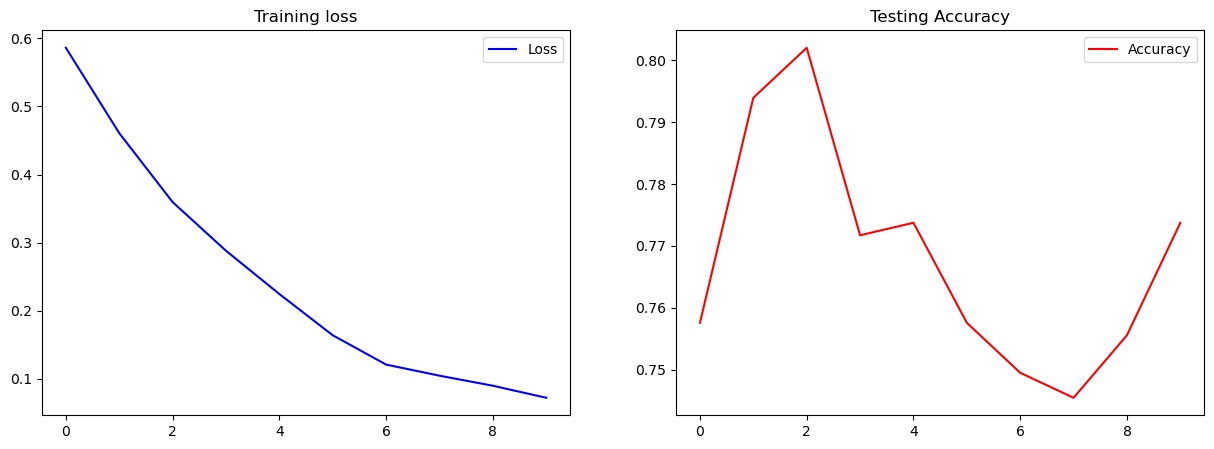

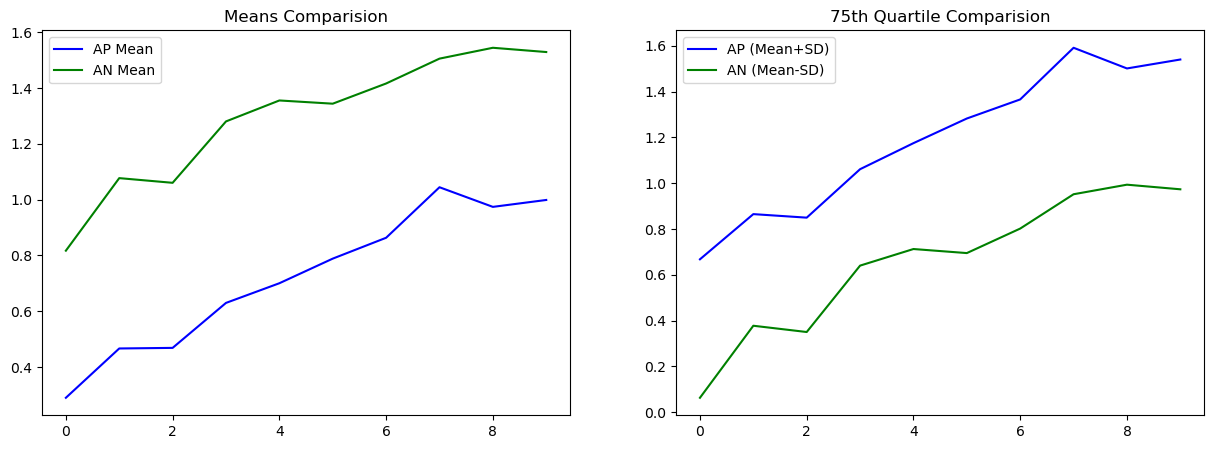

In [16]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

In [17]:
def extract_encoder(model):
    encoder = get_encoder((dims[0], dims[1], 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

In [18]:
#Paper used 1.3 thresh
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

2023-05-01 14:43:42.390819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 174ms/step

Accuracy of model: 0.689453125



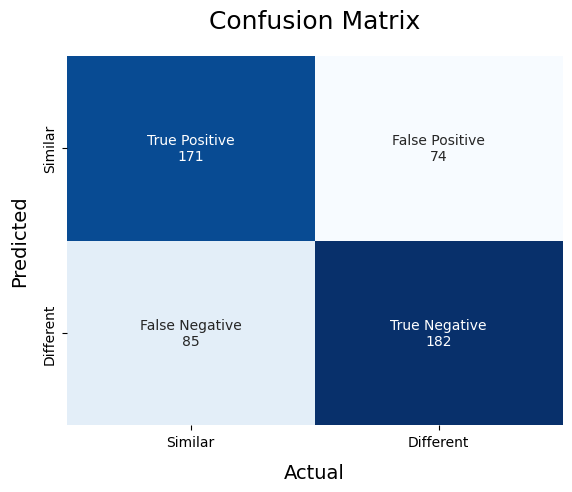

In [19]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred).T

    categories  = ['Similar','Different']
    names = ['True Positive','False Positive', 'False Negative','True Negative']
#     percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    counts = cf_matrix.flatten()

#     labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, counts)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories, cbar=False)

    plt.xlabel("Actual", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Predicted"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

8/8 [==============================] - 1s 174ms/step


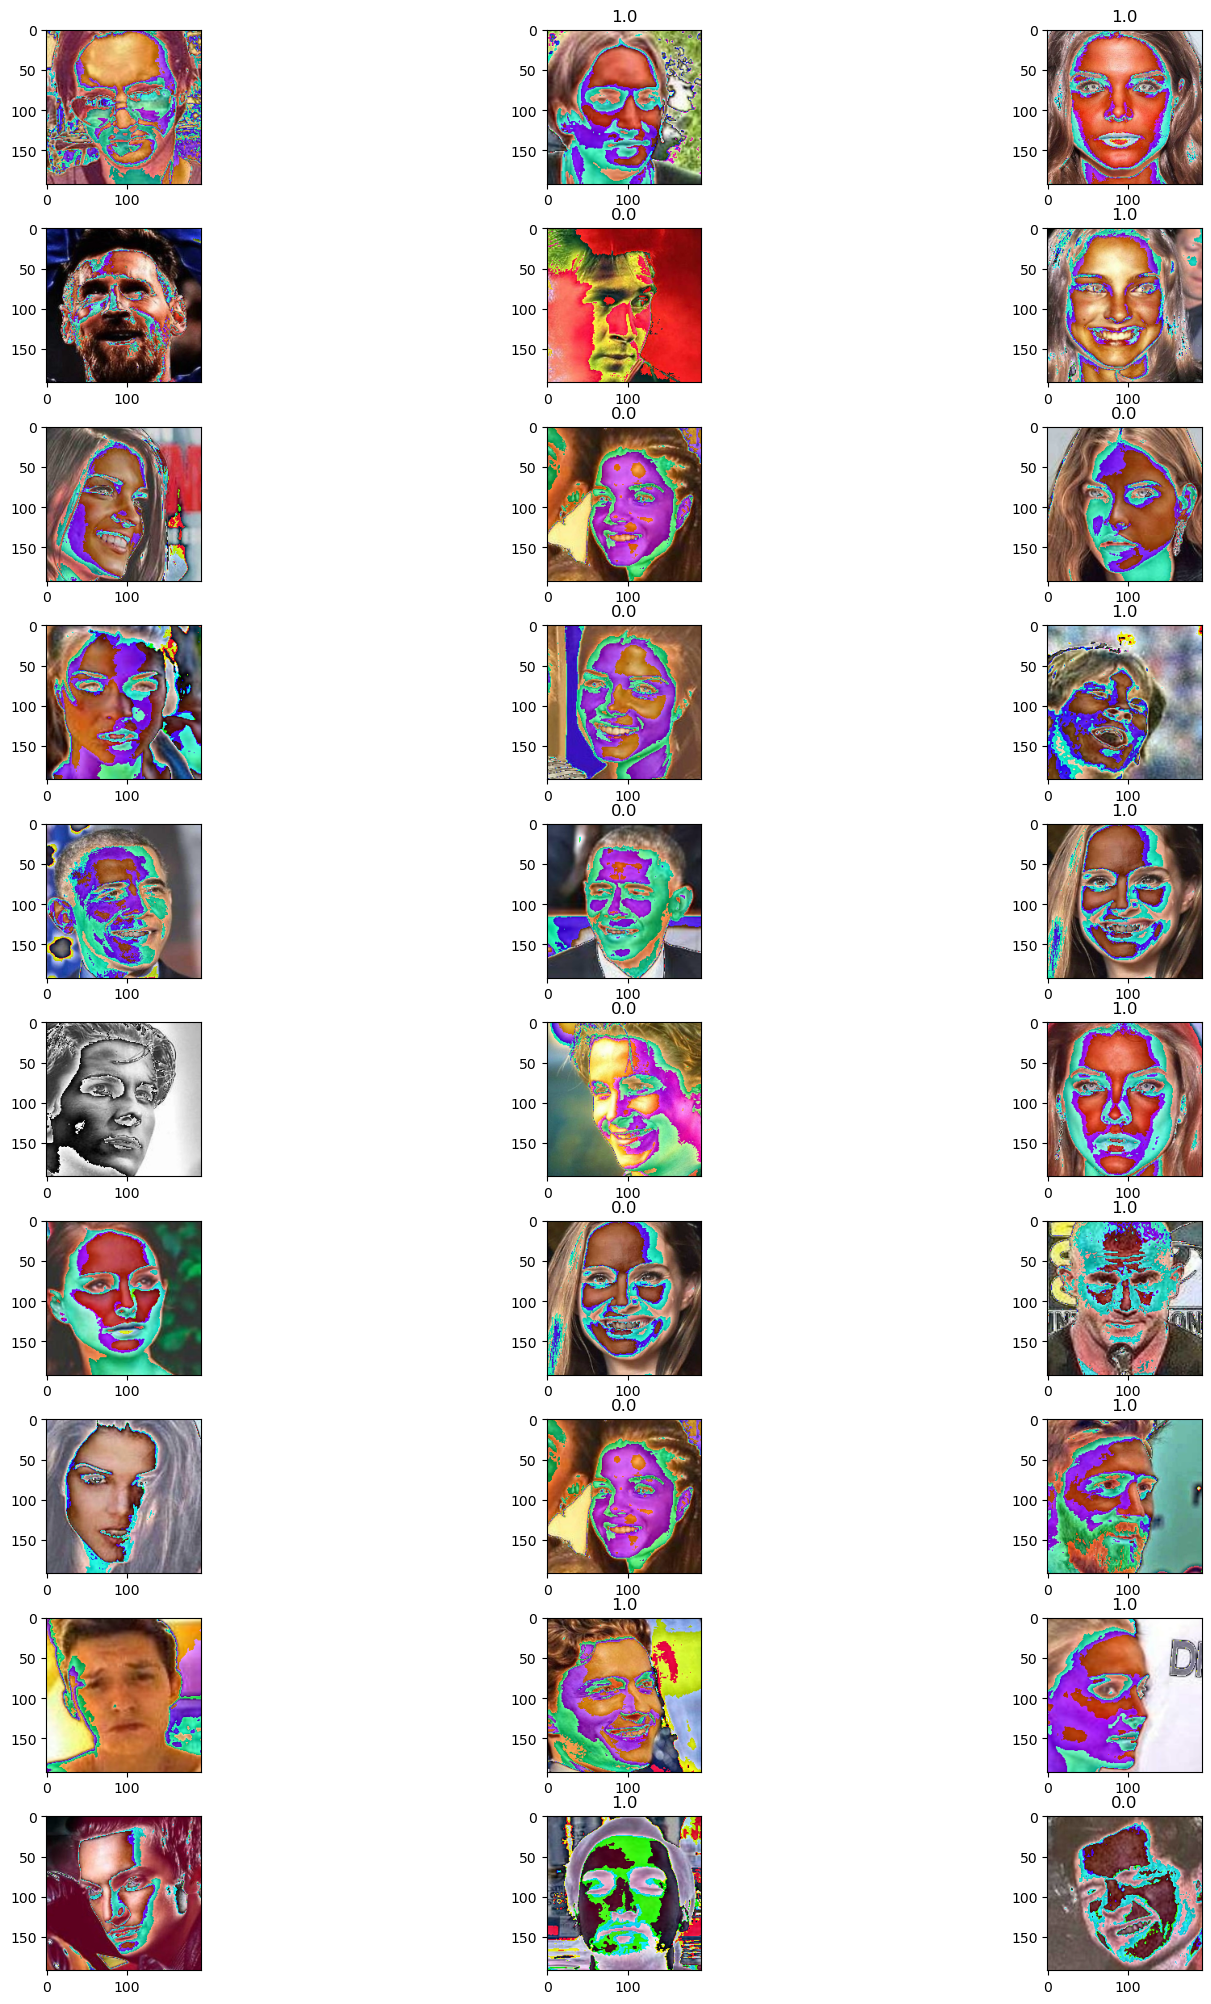

In [20]:
plot_ct = 20

start=10
f, axes = plt.subplots(plot_ct-start, 3, figsize=(15, 20))
f.tight_layout()
f.subplots_adjust(wspace=0.2)


for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    for i in range(start,plot_ct):
        axes[i-start, 0].imshow((a[i]*255).astype(np.uint8))
        axes[i-start, 1].imshow((p[i]*255).astype(np.uint8))
        axes[i-start,1].title.set_text(pos_list[i])
        axes[i-start, 2].imshow((n[i]*255).astype(np.uint8))
        axes[i-start,2].title.set_text(neg_list[i])
        i+=1
    break

8/8 [==============================] - 1s 174ms/step


NameError: name 'Image' is not defined

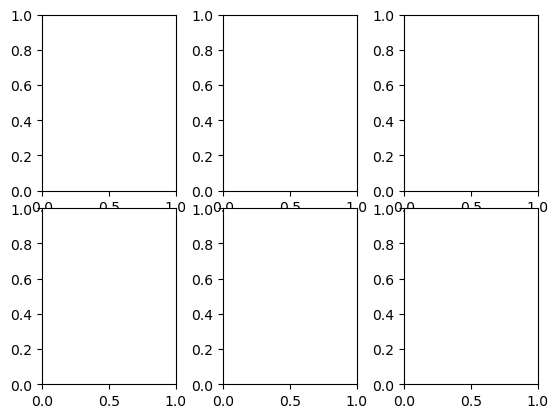

In [21]:
plot_ct = 10

f, axes = plt.subplots(2, 3)
f.subplots_adjust(hspace=0.1, wspace=0.35)

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    for i in range(0,plot_ct+start):
        if i ==15:
            axes[0, 0].imshow(Image.open(os.path.join(ROOT, test_triplet[i][0][0], test_triplet[i][0][1])).resize(dims))
#             axes[0].title.set_text("Marie Avgeropoulos (Original)")
#             axes[1].imshow((n[i]*255).astype(np.uint8))
            axes[0, 1].imshow(Image.open(os.path.join(ROOT, test_triplet[i][1][0], test_triplet[i][1][1])).resize(dims))
#             axes[1].title.set_text("Marie Avgeropoulos (Encoded)")
            axes[0, 2].imshow(Image.open(os.path.join(ROOT, test_triplet[i][2][0], test_triplet[i][2][1])).resize(dims))
            axes[1, 0].imshow((a[i]*255).astype(np.uint8))
            axes[1, 1].imshow((p[i]*255).astype(np.uint8))
            axes[1, 2].imshow((n[i]*255).astype(np.uint8))
#         i+=1
    break

In [ ]:
from PIL import Image

f, axes = plt.subplots(1, 3, figsize=(15, 20))
ind = 305

pred_map = {0: "Same", 1: "Different"}

axes[0].title.set_text(f"Anchor Image: {test_triplet[ind][0][0][5:].title()}")
axes[1].title.set_text(f"Predicted: {pred_map[pred[ind]]}")
axes[2].title.set_text(f"Predicted: {pred_map[neg_list[ind]]}")

for i in range(0,3):
    axes[i].imshow(Image.open(os.path.join(ROOT, test_triplet[ind][i][0], test_triplet[ind][i][1])))

In [ ]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break